# Cash Ratio Optimization

## Import Library and Read Data

In [ ]:
# Math Equation and data manipulation
import pandas as pd 
import numpy as np 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime object manipulation and Time series modelling
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_log_error

# Plot styling
# 0 or False for Light mode
# 1 or True for Dark Mode

dark = 0

if dark:
    plt.style.use('dark_background')
else:
    plt.style.use('seaborn')

Untuk mengecek data yang hilang perlu dicek kembali dari tanggal pertama hingga terakhir apakah ada hari yang terlewat

In [ ]:
# Open Data
data = pd.read_csv('Data/train.csv')
desc = pd.read_csv('Data/data_description.csv')

# Set "periode" to Datetime object
data['periode'] = pd.to_datetime(data['periode'])

# Set "periode" to index and reindex date to get missing date
data = data.set_index('periode')
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1]))
data = data.shift(1,freq='D')

# Make day column to get day in week
data['day'] = [i.weekday()+1 for i in data.index]

# Save missing date in variabel mising
missing = data[data['cash_in_echannel'].isna()].index

print('! Basic Information !')
print()
print('Rows'.ljust(10),':',data.shape[0],'Rows')
print('Columns'.ljust(10),':',data.shape[1],'Columns')
print('Missing'.ljust(10),':',len(missing),'Rows')
print('Start'.ljust(10),':',data.index[0])
print('End'.ljust(10),':',data.index[-1])

! Basic Information !

Rows       : 428 Rows
Columns    : 13 Columns
Missing    : 3 Rows
Start      : 2019-08-01 00:00:00
End        : 2020-10-01 00:00:00


In [ ]:
print('! List Variabel !'.center(100))
print()

for i in range(12):
    print(desc.iloc[i,0].ljust(26),':',desc.iloc[i,2])

                                         ! List Variabel !                                          

cash_in_echannel           : Total Kas Masuk pada kas eChannel (ATM dan CRM)
cash_out_echannel          : Total Kas keluar pada kas eChannel (ATM dan CRM)
cash_in_kantor             : Total kas masuk pada kas kantor
cash_out_kantor            : Total kas keluar pada kas kantor
cr_ketetapan_total_bkn_sum : Maksimum cash ratio yang dii tetapkan kantor pusat
giro                       : Total simpanan giro
deposito                   : Total simpanan deposito
kewajiban_lain             : Simpanan selain giro tabungan dan deposito ,salah satunya adalah surat berharga yang diterbitkan
tabungan                   : Total simpanan tabungan
rata_dpk_mingguan          : rata - rata saldo DPK mingguan
kas_kantor                 : Total Dari kas kantor
kas_echannel               : Total dari kas eChannel


Untuk mengatasi data yang hilang diisi dengan nilai 0 pada variabel `cash_in_kantor` dan `cash_out_kantor`, untuk variabel `kas_kantor` diisi dengan metode forward fill yaitu nilai di index sebelumnya diisi untuk nilai yang hilang, sedangkan untuk variabel sisanya diisi dengan metode interpolasi yaitu dengan mengambil nilai tengah dari nilai di index sebelum dan sesudahnya.

In [47]:
# Missing Value Treatment
data.iloc[:,2:4] = data.iloc[:,2:4].fillna(0)
data['kas_kantor'] = data['kas_kantor'].ffill()
data = data.interpolate()

# Kas Echannel

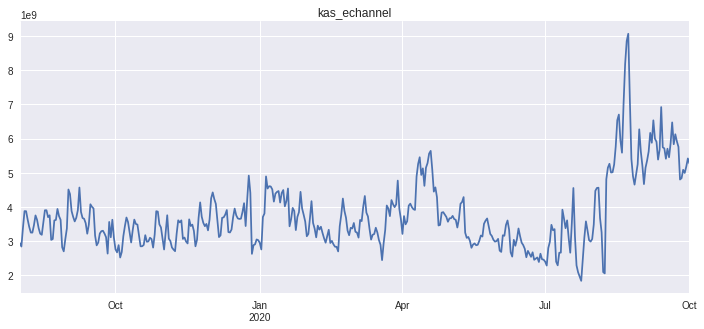

In [ ]:
# Time series Plot 
plt.figure(figsize=(12,5))
data['kas_echannel'].plot(title='kas_echannel')
plt.show()

Dalam exponential smoothing terdapat 2 model yaitu model `additive` dan model `multiplicative`. Untuk melihat model yang cocok maka dilakukan dekomposisi.

In [ ]:
# Breakdown Seasonality and trend with additive model
dec_e_a = seasonal_decompose(data['kas_echannel'], model='a')

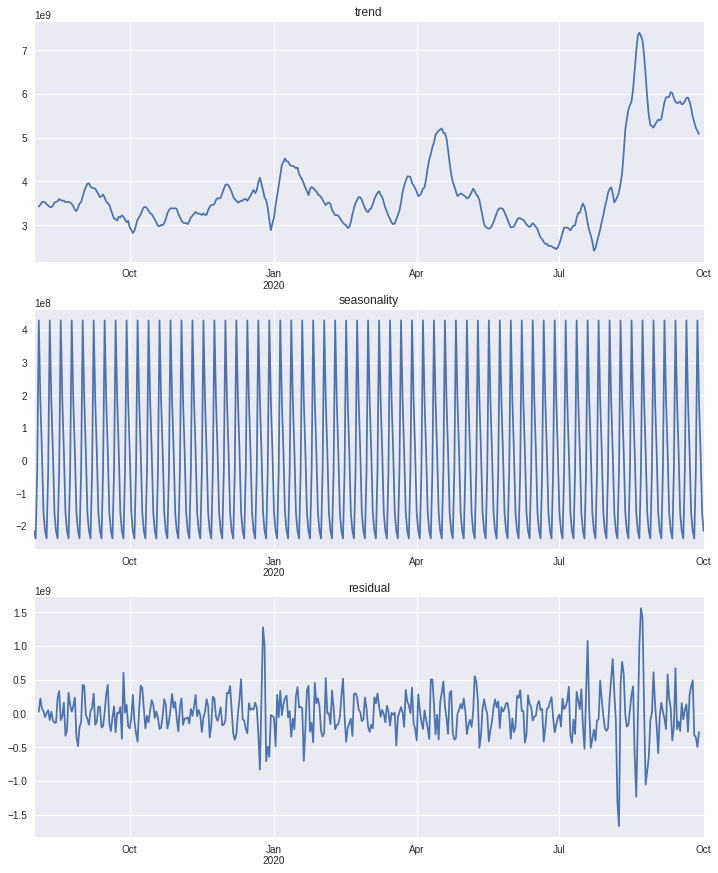

In [ ]:
# Plot seasonality and trend component
fig, ax = plt.subplots(3,1,figsize=(12,15))
dec_e_a.trend.plot(ax=ax[0], title='trend')
dec_e_a.seasonal.plot(ax=ax[1], title='seasonality')
dec_e_a.resid.plot(ax=ax[2],title='residual')
plt.subplots_adjust(hspace=0.2)

In [ ]:
# Breakdown Seasonality and trend with multiplicative model
dec_e_m = seasonal_decompose(data['kas_echannel'], model='m')

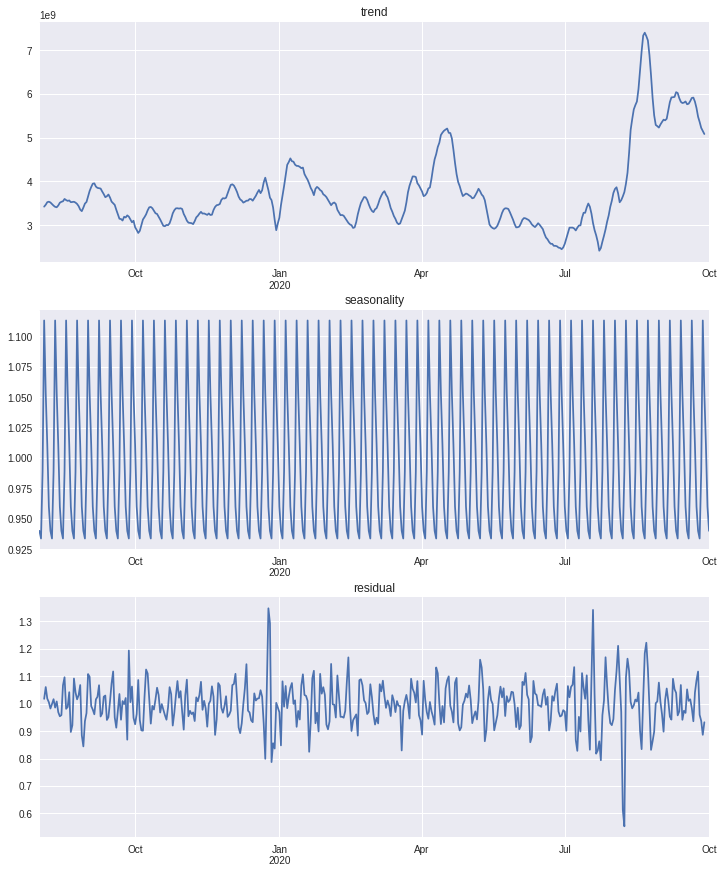

In [ ]:
# Plot seasonality and trend component
fig, ax = plt.subplots(3,1,figsize=(12,15))
dec_e_m.trend.plot(ax=ax[0], title='trend')
dec_e_m.seasonal.plot(ax=ax[1], title='seasonality')
dec_e_m.resid.plot(ax=ax[2],title='residual')
plt.subplots_adjust(hspace=0.2)

Untuk Model yang cocok untuk variabel `kas_echannel` ini, untuk trendnya model `additive` dan untuk seasonalnya `multiplicative` dan seasonal_periodenya 7

In [27]:
# Creating Model
model_e = ExponentialSmoothing(trend='add',
                               seasonal='mul',
                               seasonal_periods=7,
                               endog=data['kas_echannel'], 
                               damped=True)

In [28]:
# Fitting Model
model_e = model_e.fit(use_boxcox=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [31]:
# Forecasting
pr_e = model_e.predict(start=dt.datetime(2020,10,2),end=dt.datetime(2020,11,1))

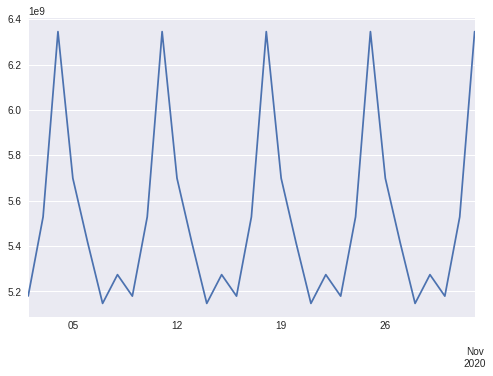

In [32]:
# Plotting Prediction
pr_e.plot()

# Kas Kantor

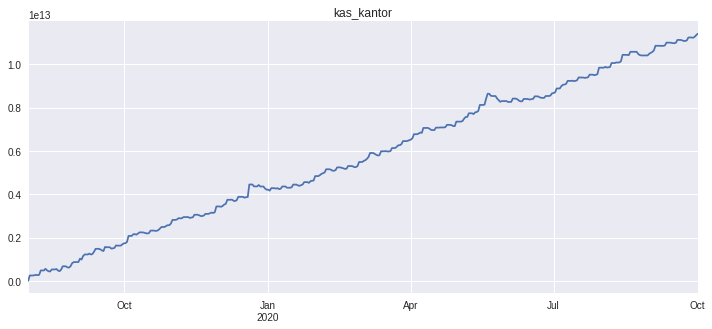

In [33]:
# Plot Time series
plt.figure(figsize=(12,5))
data['kas_kantor'].plot(title='kas_kantor')

In [34]:
# Breakdown Seasonality and trend with additive model
dec_k_a = seasonal_decompose(data['kas_kantor'], model='a')

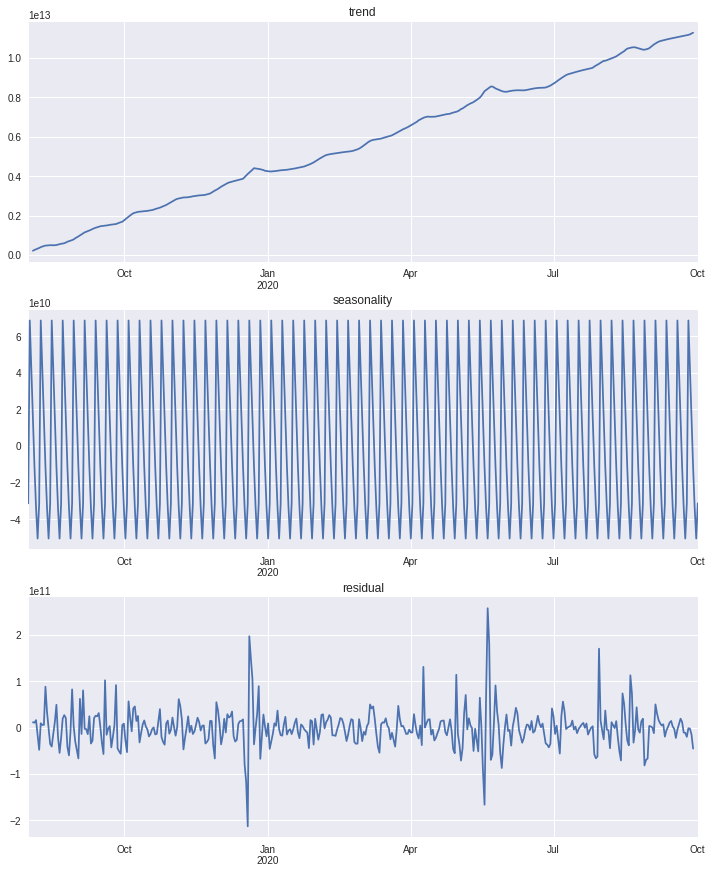

In [ ]:
# Plot seasonality and trend component
fig, ax = plt.subplots(3,1,figsize=(12,15))
dec_k_a.trend.plot(ax=ax[0], title='trend')
dec_k_a.seasonal.plot(ax=ax[1], title='seasonality')
dec_k_a.resid.plot(ax=ax[2],title='residual')
plt.subplots_adjust(hspace=0.2)

In [ ]:
# Breakdown Seasonality and trend with multiplicative model
dec_k_m = seasonal_decompose(data['kas_kantor'], model='m')

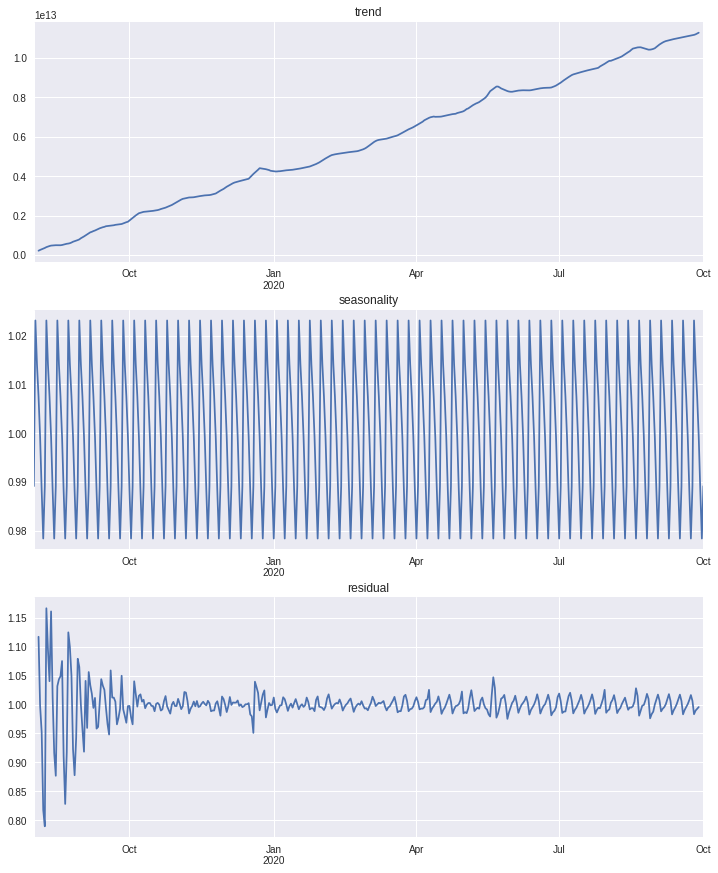

In [ ]:
# Plot seasonality and trend component
fig, ax = plt.subplots(3,1,figsize=(12,15))
dec_k_m.trend.plot(ax=ax[0], title='trend')
dec_k_m.seasonal.plot(ax=ax[1], title='seasonality')
dec_k_m.resid.plot(ax=ax[2],title='residual')
plt.subplots_adjust(hspace=0.2)

Untuk Model yang cocok untuk variabel `kas_kantor` ini, untuk trendnya model `multiplicative` dan untuk seasonalnya `additive` dan seasonal_periodenya 7

In [35]:
# Creating Model
model_k = ExponentialSmoothing(trend='mul',
                               seasonal='add',
                               seasonal_periods=7,
                               endog=data['kas_kantor'],
                               damped=True)

In [36]:
# Fitting Model
model_k = model_k.fit(use_boxcox=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [40]:
# Forecasting
pr_k = model_k.predict(start=dt.datetime(2020,10,2),end=dt.datetime(2020,11,1))

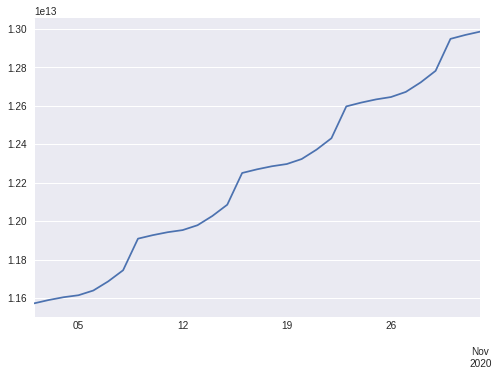

In [41]:
# Plotting Prediction
pr_k.plot()

# Cross Validation

In [58]:
def expanding_windows(x, length, num, boxcox=False,**kwargs):
    """
        Fungsi untuk cross validation exponential smoothing 
        dengan metode expanding windows.
    """
    scores = []
    preds = []
    for i in range(num, 0, -1):
        train = x[:-(length*i)]
        test = x[-(length*i):-(length*(i-1)) if i != 1 else len(x)]
        model = ExponentialSmoothing(endog=train, **kwargs)
        model = model.fit(use_boxcox=boxcox)
        pred = model.predict(start=x.index[-(length*i)], end = x.index[-(length*(i-1))-1])
        if not any(np.isnan(pred)):
            score = mean_squared_log_error(test, pred.values)**0.5
            scores.append(score)
        preds.append([test, pred])
    return np.array(scores), preds

In [99]:
# Cross Validation Kas echannel
cv_e = expanding_windows(x=data['kas_echannel'], 
                         length=31, 
                         num=3, 
                         boxcox=False,
                         trend='add',
                         seasonal='mul',
                         seasonal_periods=7,
                         damped=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [100]:
# Cross Validation
cv_k = expanding_windows(x=data['kas_kantor'], 
                         length=31, 
                         num=3, 
                         boxcox=False,
                         trend='mul',
                         seasonal='add',
                         seasonal_periods=7,
                         damped=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [101]:
# CV Score kas_echannel
print('CV kas_echannel:', cv_e[0].mean())

CV kas_echannel: 0.31288893462991224


In [102]:
# CV Score kas_kantor
print('CV kas_kantor:',cv_k[0].mean())

CV kas_kantor: 0.02769820627735586


In [103]:
def cv_gabung(x, y):
    scores = []
    for i in range(len(x[0])):
        if not any(np.isnan(x[1][i][1])) and not any(np.isnan(y[1][i][1])):
            true = list(x[1][i][0]) + list(y[1][i][0])
            pred = list(x[1][i][1]) + list(y[1][i][1])
            score = mean_squared_log_error(true, pred)**0.5
            scores.append(score)
    return np.array(scores)

In [98]:
# CV Gabungan
print('CV Gabungan :',cv_gabung(cv_e,cv_k).mean())

CV Gabungan : 0.22219513263976579


# Submission

In [42]:
test = pd.read_csv('Data/test.csv')

In [43]:
value = list(pr_k) +list(pr_e)

In [44]:
test['value'] = value

In [45]:
test.to_csv('submission.csv',index=False)